[![Le Baladin](https://img.shields.io/badge/Le_baladin-Ciboulette_Messier_34-blue.svg)](https://sites.google.com/view/astronomie-ut1/accueil)

_Dominique Touzan_<sup>1,2</sup>

<sup>1</sup>Notebook: https://github.com/dtouzan/Jupyter/blob/master/ciboulette-messier34.ipynb

<sup>2</sup>Correspondance: [dtouzan@gmail.com](mailto:dtouzan@gmail.com)

Édition   1.0, révision 20/11/2020 - 22/11/2020

---
**Résumé** : Ciboulette avec une focale de deux cent millimètres. Quatre images bonnes sur un lot de douze, sacrée météorologie. Une carte des étoiles est éditée en fonction du champ observé en interrogeant le catalogue GSC2.3 du service Vizier[[1]](#ref1). Visualisation toute simple de l'amas Messier 34 du 19 novembre 2020. 

_Mots-clés_ : Amas - Indilib

---
[![astropy](http://img.shields.io/badge/powered%20by-AstroPy-orange.svg?style=flat)](http://www.astropy.org/) [![indilib](http://img.shields.io/badge/powered%20by-Indilib-orange.svg?style=flat)](http://www.indilib.org)

## Configuration

In [3]:
import numpy as np
import time
from IPython.display import Image
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import wcs
from astropy import units as u
from astropy.time import Time
from astropy.io import ascii
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
import astropy.coordinates as coord
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from matplotlib.colors import LogNorm
import os

In [4]:
object_name = 'M34' # Pas d'espace
time_shoot = '30' # En seconde
#inc_RA_deg = 0.17 # Incrément de déplacement de la monture en RA
#inc_DEC_deg = -1.4 # Incrément de déplacement de la monture en DEC
inc_RA_deg = 0.0010 # Incrément de déplacement de la monture en RA
inc_DEC_deg = 0.00005 # Incrément de déplacement de la monture en DEC
frame = [[1,2,3,4],[5,6,7,8],[9,10,11,12]] # Nombre d'image 4 x DEC par 3 x RA
dataset = '/home/data-set/GC_' # Répertoire de stockage
simulation = False
index = 0
i_column = len(frame)-1

## Prise de vue

In [7]:
# Indi Client

# Pour test sans monture 
if simulation :
    RA = '0.42000'
    DEC = '44.38027'
    LAT = '49.52'    
    LONG = '359.7'
    time_shoot = '1' # in second No space

for frameid in frame :
    i_line = len(frameid)-1
    
    for idx in frameid :
    
        print('>Shoot...')
        os.system("./indiCL.sh" + " " + object_name + " " + time_shoot)
        
        if not simulation :
            # Lecture RA
            data = ascii.read("COORD_RA.csv",data_start = 0,format = 'csv') 
            for line in data :
                RA = line[0]
    
            # Lecture DEC
            data = ascii.read("COORD_DEC.csv",data_start = 0,format = 'csv') 
            for line in data :
                DEC = line[0]
    
            # Lecture LAT
            data = ascii.read("COORD_LAT.csv",data_start = 0,format = 'csv') 
            for line in data :
                LAT = line[0]
    
            # Lecture LONG
            data = ascii.read("COORD_LONG.csv",data_start = 0,format = 'csv') 
            for line in data :
                LONG = line[0]

        # RA.deg, DEC.deg for WCS
        RA_deg = (15*float(RA))
        DEC_deg = float(DEC) 
    
        # Lecture du filtre
        data = ascii.read("SLOT_VALUE.csv",data_start = 0,format = 'csv') 
        for line in data :
            filter_name = line[0]
    
        # Lecture de la focale
        data = ascii.read("TELESCOPE_FOCAL.csv",data_start = 0,format = 'csv') 
        for line in data :
            focale = line[0]
     
        # mini-log
        print('>RA '+str(RA)+'   DEC '+str(DEC)+'   FRAME '+str(idx)+'   FILTER '+str(filter_name))
           
        # Modification des entêtes fits
        if (idx < 10) :
            print('>' + dataset + '00' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '00' + str(idx) + '.fits')
        else : 
            print('>' + dataset + '0' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '0' + str(idx) + '.fits')             
            
        fits.setval(fits_file, 'RADESYSA', value='ICRS', comment='Equatorial coordinate system', savecomment=True)
        fits.setval(fits_file, 'FRAMEID', value=idx+index, comment='Frame ID', savecomment=True)
        fits.setval(fits_file, 'FILTER', value=filter_name, comment='Filter name', savecomment=True)
        fits.setval(fits_file, 'SITELAT', value=LAT, comment='Observatory latitude', savecomment=True)
        fits.setval(fits_file, 'SITELONG', value=LONG, comment='Observatory longitude', savecomment=True)
        fits.setval(fits_file, 'EQUINOX', value=2000.0, comment='Equinox date', savecomment=True)
        fits.setval(fits_file, 'DATATYPE', value='Intensity', comment='Type of data', savecomment=True)
        fits.setval(fits_file, 'MJD-OBS', value=0.0, comment='MJD of start of obseration', savecomment=True)
        fits.setval(fits_file, 'JD-OBS', value=0.0, comment='JD of start of obseration', savecomment=True)

        hdu = fits.open(fits_file)[0]
        header = hdu.header

        # Modification du nom du télescope
        header['TELESCOP'] = 'UT2'

        # Modification du JD et MJD
        date_obs = header['DATE-OBS']
        time_obs = Time(header['DATE-OBS'])
        header['JD-OBS'] = time_obs.jd
        header['MJD-OBS'] = time_obs.mjd

        # Eléments pour CRPIX
        crpix1 = int(header['NAXIS1'])/2
        crpix2 = int(header['NAXIS2'])/2

        # Elément pour CDELT
        cdelt1 = (206*int(header['PIXSIZE1'])*int(header['XBINNING'])/focale)/3600
        cdelt2 = (206*int(header['PIXSIZE2'])*int(header['YBINNING'])/focale)/3600

        # Header WCS
        w = wcs.WCS(naxis=2)
        w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        # CRVAL position RA,DEC en degrés
        w.wcs.crval = [RA_deg, DEC_deg] 
        # CRPIX Vecteur à 2 éléments donnant les coordonnées X et Y du pixel de référence 
        # (def = NAXIS / 2) dans la convention FITS (le premier pixel est 1,1)
        w.wcs.crpix = [crpix1, crpix2]
        # CDELT Vecteur à 2 éléments donnant l'incrément physique au pixel de référence
        w.wcs.cdelt = [-cdelt1, cdelt2] 

        # Now, write out the WCS object as a FITS header
        hdu.header = header + w.to_header()
        # Modification des NAXIS

        # Header and data
        hdr = hdu.header
        data = np.fliplr(hdu.data) # inversion verticale

        if (idx < 10) :
            print('>' + dataset + object_name + '_00' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_00' + str(idx) + '.fits', data, hdr)
        else :   
            print('>' + dataset + object_name + '_0' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_0' + str(idx) + '.fits', data, hdr)

        if i_line > 0 :
            # Déplacement de la monture en DEC
            print('>Track DEC...')
            RA = str(RA)
            DEC = str(float(DEC) + inc_DEC_deg)
            if not simulation :
                os.system("./indiTrack.sh" + " " + RA + " " + DEC)
 
            i_line = i_line - 1
        # Fin boucle DEC
    
    if i_column > 0 : 
        # Déplacement de la monture en RA
        print('>Track RA... positionnement')
        RA = str(float(RA) + inc_RA_deg)
        DEC = str(float(DEC) - (3 * inc_DEC_deg))   
        if not simulation :
            os.system("./indiTrack.sh" + " " + RA + " " + DEC)
        
        # Attente de 10s pour déplacement long  
        time.sleep(10) 
        index = index + 4
        i_column = i_column - 1
    # Fin boucle RA
    

>Shoot...
>RA 2.69   DEC 42.8   FRAME 1   FILTER L
>/home/data-set/GC_001.fits
>/home/data-set/GC_M34_001.fits
>Track DEC...
>Shoot...
>RA 2.69   DEC 42.8   FRAME 2   FILTER L
>/home/data-set/GC_002.fits
>/home/data-set/GC_M34_002.fits
>Track DEC...
>Shoot...
>RA 2.69   DEC 42.8   FRAME 3   FILTER L
>/home/data-set/GC_003.fits
>/home/data-set/GC_M34_003.fits
>Track DEC...
>Shoot...
>RA 2.69   DEC 42.8   FRAME 4   FILTER L
>/home/data-set/GC_004.fits
>/home/data-set/GC_M34_004.fits
>Track RA... positionnement
>Shoot...
>RA 2.69   DEC 42.78333333333333   FRAME 5   FILTER L
>/home/data-set/GC_005.fits
>/home/data-set/GC_M34_005.fits
>Track DEC...
>Shoot...
>RA 2.6883333333333335   DEC 42.78333333333333   FRAME 6   FILTER L
>/home/data-set/GC_006.fits
>/home/data-set/GC_M34_006.fits
>Track DEC...
>Shoot...
>RA 2.6883333333333335   DEC 42.78333333333333   FRAME 7   FILTER L
>/home/data-set/GC_007.fits
>/home/data-set/GC_M34_007.fits
>Track DEC...
>Shoot...
>RA 2.6883333333333335   DEC 42.78

In [7]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
# La grosseur des étoiles est dans le tableau table_Marker
#
def RegionInCatalog(astre_ra,astre_dec,angle_width,angle_height,mag,catalog_name,field_ra,field_dec,field_mag):
    # Création du tableau
    table_ra = []
    table_dec = []
    table_marker = []
    
    # Recherche dans le catalog 
    # Field catalog : _RAJ2000, _DEJ2000, Vmag, r'mag, Gmag ...
    v = Vizier(columns=[field_ra, field_dec, field_mag])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog=catalog_name,column_filters={'Vmag':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            ra = float(line[0])
            dec = float(line[1])
            Mv = float(line[2])
            if Mv != 'masked' :
                marker_size = 1
                if Mv < 12:
                    marker_size = 1
                if Mv < 11:
                    marker_size = 1    
                if Mv < 10:
                    marker_size = 3  
                if Mv < 9:
                    marker_size = 5
                if Mv < 8:
                    marker_size = 8
                if Mv < 7:
                    marker_size = 20
                if Mv < 6:
                    marker_size = 35
                if Mv < 5:
                    marker_size = 50
                table_ra.append(ra)
                table_dec.append(dec)
                table_marker.append(marker_size)
                
            else :
                table_ra.append(ra)
                table_dec.append(dec)
                table_Marker.append(0)
        
        return Table([table_ra,table_dec,table_marker], names=['RA', 'DEC', 'MARKER'])

## Tableau des prises de vue

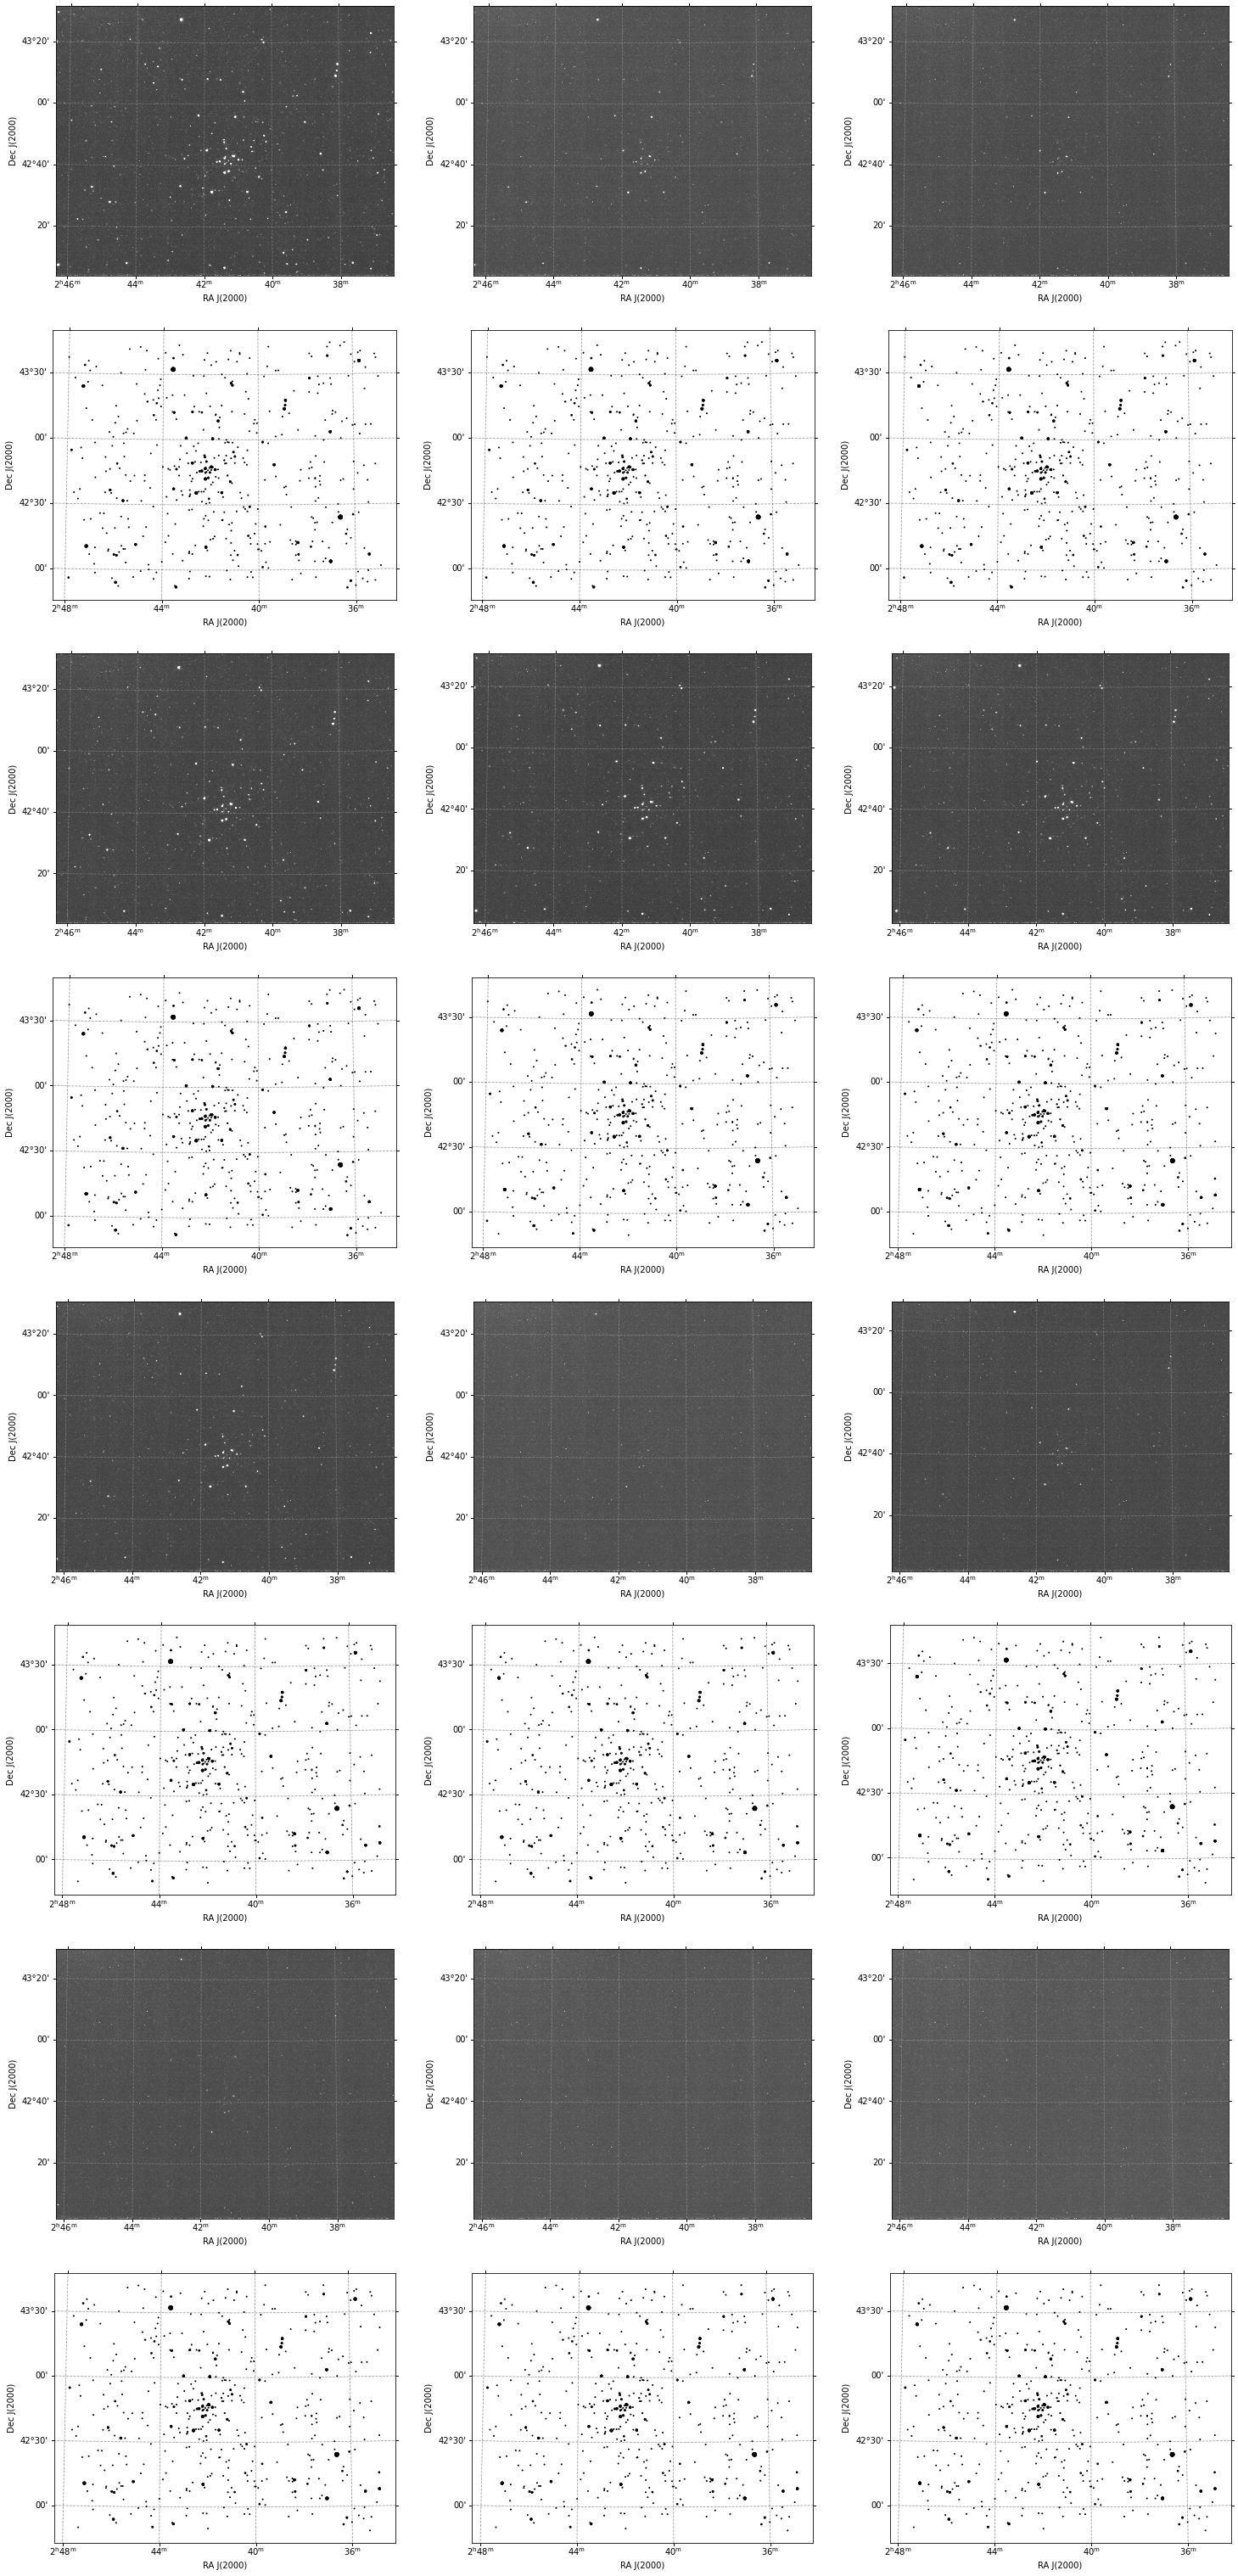

In [18]:
frame = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
fig = plt.figure(figsize=(25,55))
column = 1
for frameid in frame :
    for idx in frameid :
        if (idx < 10) :
            fits_file = get_pkg_data_filename(dataset + object_name + '_00' + str(idx) + '.fits')
        else :   
            fits_file = get_pkg_data_filename(dataset + object_name + '_0' + str(idx) + '.fits')
        hdu = fits.open(fits_file)[0]
        wcs_file = wcs.WCS(hdu.header)
        header = hdu.header
        RA_deg = float(header['CRVAL1'])
        DEC_deg = float(header['CRVAL2'])      
        EQUINOX = str(int(header['EQUINOX']))
        mag = 12
        catalog = 'GSC2.3'
        data_field = RegionInCatalog(RA_deg, DEC_deg,2.4,1.9,mag,catalog,'_RAJ2000', '_DEJ2000', 'Vmag')
    
        ax = fig.add_subplot(8,3,column, projection=wcs_file)
        fig.add_axes(ax) 
        ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
        plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = 0, vmax = 45)
        plt.xlabel('RA J('+EQUINOX+')')
        plt.ylabel('Dec J('+EQUINOX+')')
        
        ax = fig.add_subplot(8,3,column+3, projection=wcs_file)
        ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.40)
        plt.imshow(hdu.data, origin='lower', cmap='binary',vmin = 0, vmax = 0)
        ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER'],edgecolor='black', facecolor='black')
        plt.xlabel('RA J('+EQUINOX+')')
        plt.ylabel('Dec J('+EQUINOX+')')
        column = column + 1
        
    column = column + 3
             
plt.show()

## Mosaïque

Création de la mosaïque avec seulement quatre images car le temps se couvre. La résolution est de 5.35 arc-seconde/pixel dans la fonction "find_optimal_celestial_wcs"

In [9]:
# table : table des noms de fichier fits
table_fits = []

for idx in range(1,6) :
    
    if (idx < 10) :
        fits_name = dataset + object_name + '_XY_00' + str(idx) + '.fits'
    else :   
        fits_name = dataset + object_name + '_XY_0' + str(idx) + '.fits'
    table_fits.append(get_pkg_data_filename(fits_name))

# table : table de fichier fits
table = []

for line in table_fits : 
    table.append(fits.open(line))
    
# hdus : liste des hdu des fichier fits
hdus = []

for file in table :
    hdus.append(file[0])


# Sortie des WCS et tailles des images et recalibration.
wcs_out, shape_out = find_optimal_celestial_wcs(hdus, frame='icrs',  projection='TAN', resolution=5.35 * u.arcsec)
# Pour affichage des résultats
hdr = wcs_out.to_header()


# Création de la mosaïc et des champs visuels
mosaic, footprint = reproject_and_coadd(hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp,combine_function = 'mean', match_background = True, background_reference = 2)

## Affichage

Même après la mosaïque des quatre images en mode "mean" des points chauds de la PL1-M apparaissent.

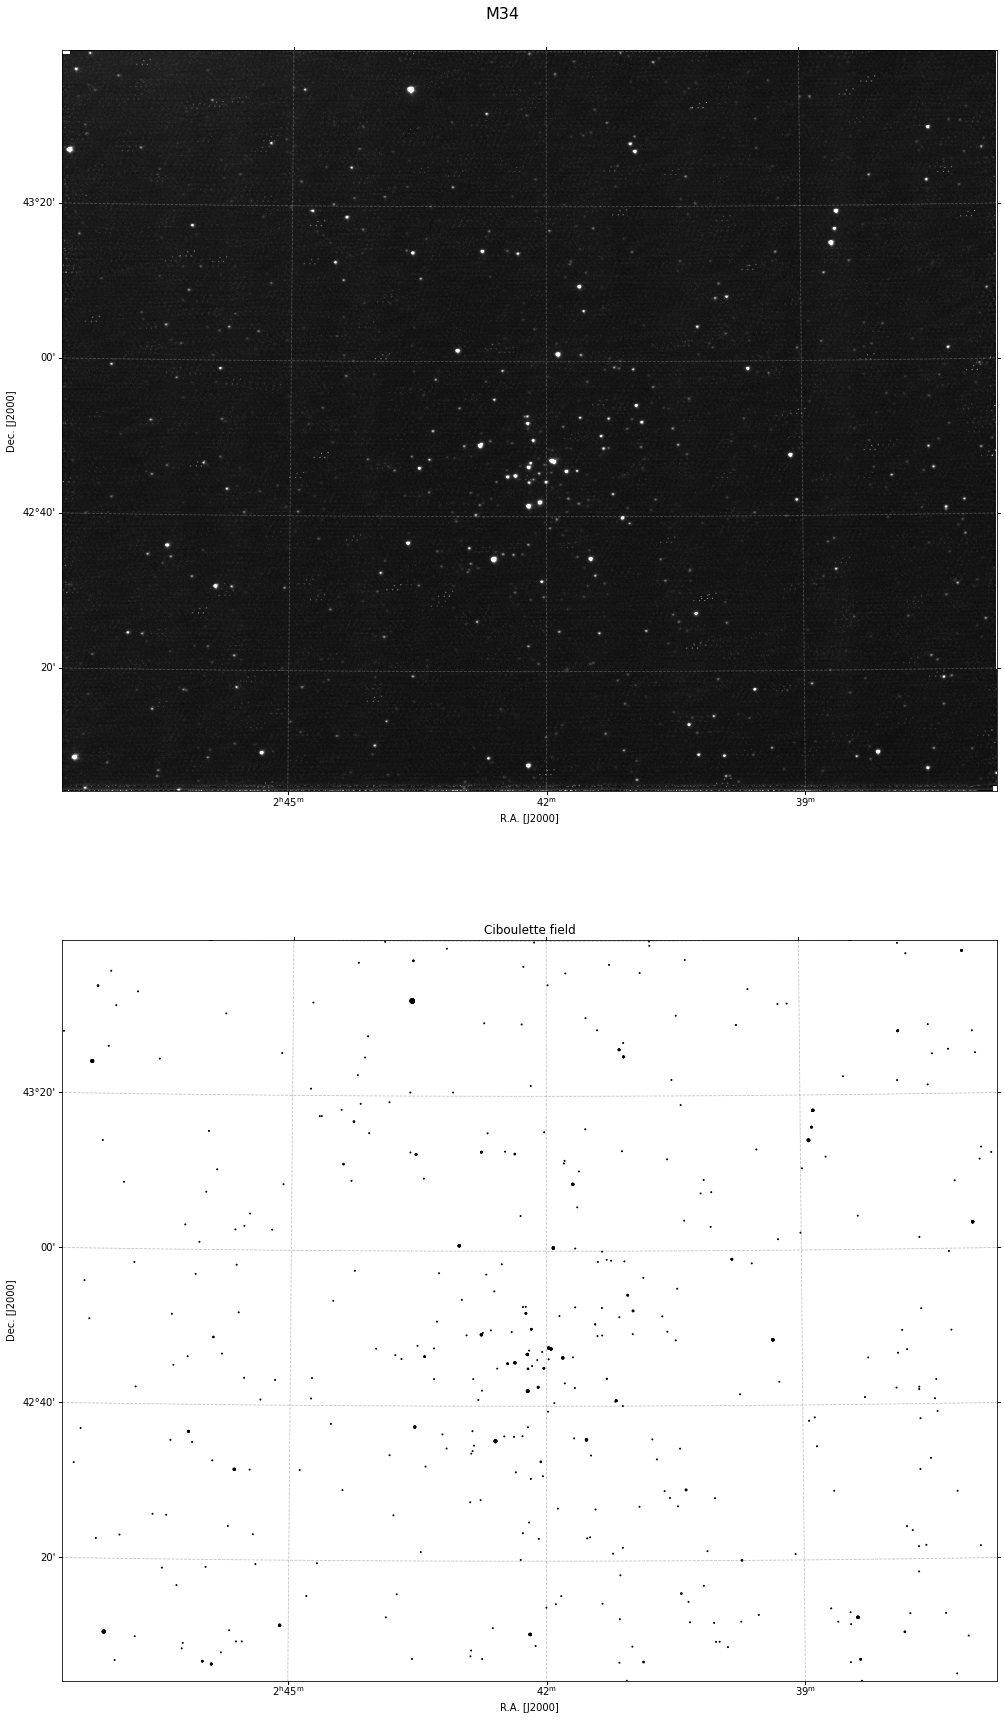

In [22]:
fig = plt.figure(figsize=(30, 30))
ax = plt.subplot(211, projection = wcs_out)
ax.grid(b = False, alpha = 0)

RA_deg = float(hdr['CRVAL1'])
DEC_deg = float(hdr['CRVAL2'])
im = ax.imshow(mosaic, cmap='gray', origin='lower', vmin=8, vmax=55)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
plt.xlabel('R.A. [J2000]')
plt.ylabel('Dec. [J2000]')
fig.suptitle(object_name, y = 0.9, fontsize = 16)

mag = 12
catalog = 'GSC2.3'
data_field = RegionInCatalog(RA_deg, DEC_deg,2.4,1.9,mag,catalog,'_RAJ2000', '_DEJ2000', 'Vmag')

ax = plt.subplot(212, projection = wcs_out)
ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER'],edgecolor='black', facecolor='black')
ax.set_title('Ciboulette field')
im = ax.imshow(mosaic, cmap='binary', origin='lower', vmin=0, vmax=0)
ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.25)
plt.xlabel('R.A. [J2000]')
plt.ylabel('Dec. [J2000]')
plt.show()

## Références
---

<a id='ref1'></a>
1. VizieR, https://vizier.u-strasbg.fr/viz-bin/VizieR

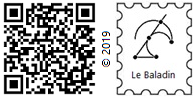

In [23]:
display(Image('signature.png'))